In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model_ev_updated.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   tile_centroid_lat            12479 non-null  float64
 6   tile_centroid_lon            12479 non-null  float64
 7   district_number              12479 non-null  int64  
 8   year                         12479 non-null  int64  
 9   Unemployment_Rate            12479 non-null  float64
 10  Average_Age                  12479 non-null  float64
 11  Elderly_Population           12479 non-null  float64
 12  Young_Population             12479 non-null  float64
 13  Total_Population

In [3]:
df['panel_area_log'] = np.log1p(df['panel_area_m2'])


In [4]:
feature_cols = [
    'year',
    'total_rooftops',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    'tile_encoded',
        "employed",
        "pv_price",
        'panel_area_lag1',
        'ev_points_164m'

]

# Drop rows with missing lag values
df_model = df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [5]:
# Binary target: 1 if there is any solar, 0 if none
df_model['has_solar'] = (df_model['panel_area_log'] > 0).astype(int)


In [6]:
# Sort just to be safe
df_model = df_model.sort_values("year")

# Identify years
test_year = df_model["year"].max()
val_year  = df_model[df_model["year"] < test_year]["year"].max()

# Split data
train_df = df_model[df_model["year"] < val_year]
val_df   = df_model[df_model["year"] == val_year]
test_df  = df_model[df_model["year"] == test_year]

# Features and target
X_train_1 = train_df[feature_cols]
y_train_1 = train_df["has_solar"]

X_val_1 = val_df[feature_cols]
y_val_1 = val_df["has_solar"]

X_test_1 = test_df[feature_cols]
y_test_1 = test_df["has_solar"]


In [7]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score

# --------------------------------------------------
# Train LightGBM using TRAIN + VALIDATION
# --------------------------------------------------

clf = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=32,
    class_weight="balanced",
    random_state=42
)

clf.fit(
    X_train_1, y_train_1,
    eval_set=[(X_val_1, y_val_1)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# --------------------------------------------------
# Evaluate on TEST (never used during training)
# --------------------------------------------------

# Probability of solar adoption
p_solar_test = clf.predict_proba(X_test_1)[:, 1]

# Metrics
test_auc = roc_auc_score(y_test_1, p_solar_test)
test_acc = accuracy_score(y_test_1, clf.predict(X_test_1))

print(f"Stage 1 TEST ROC-AUC: {test_auc:.3f}")
print(f"Stage 1 TEST Accuracy: {test_acc:.3f}")

# --------------------------------------------------
# (Optional) Inspect best iteration
# --------------------------------------------------

print("Best number of trees:", clf.best_iteration_)


[LightGBM] [Info] Number of positive: 7760, number of negative: 1591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9351, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.994626	valid_0's binary_logloss: 0.0999634
Stage 1 TEST ROC-AUC: 0.997
Stage 1 TEST Accuracy: 0.971
Best number of trees: 164


In [8]:
# Save model to file
clf.booster_.save_model("lgb_model_1Stage_lag_ev.txt")


In [9]:
# Probability of solar adoption
p_solar = clf.predict_proba(X_test_1)[:, 1]

# Optional: evaluate classifier
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc = roc_auc_score(y_test_1, p_solar)
acc = accuracy_score(y_test_1, clf.predict(X_test_1))

print(f"Stage 1 ROC-AUC: {roc_auc:.3f}, Accuracy: {acc:.3f}")


Stage 1 ROC-AUC: 0.997, Accuracy: 0.971


In [10]:
train_pos = train_df[train_df['has_solar'] == 1]
test_pos  = test_df  # keep all rows; we will multiply with p_solar later

X_train_2 = train_pos[feature_cols]
y_train_2 = train_pos['panel_area_log']  # target is log(area) to reduce skew
X_test_2  = test_df[feature_cols]


In [11]:
import xgboost as xgb
import joblib

# Load your saved Stage 2 model
# model_stage2 = xgb.XGBRegressor()
# model_stage2.load_model("stage2_xgb.json")

model_stage2 = joblib.load("random_forest_model_lag_ev.joblib")


In [12]:
# Predict log(panel_area) for all test tiles
y_pred_log = model_stage2.predict(X_test_2)

# Convert back to original scale (square meters)
import numpy as np
y_pred_size = np.expm1(y_pred_log)  # inverse of log1p


In [13]:
y_pred_final = p_solar * y_pred_size 

In [14]:
import numpy as np

# Apply your logic:
# 1. If p_solar > 0.5 -> multiply by 1.5
# 2. If p_solar < 0.2 -> set to 0
# 3. Otherwise -> keep the original y_pred_final calculation

y_pred_final = np.where(
    p_solar > 0.4, 
    (p_solar+0.25) * y_pred_size,                # High confidence boost
    np.where(
        p_solar < 0.25, 
        0,                                      # Low confidence threshold
        p_solar * y_pred_size                   # Default behavior (0.2 to 0.5)
    )
)

In [15]:
print(p_solar)

[0.99886101 0.99668096 0.99928411 ... 0.99896094 0.99862156 0.99882339]


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error

# Convert y_test back to original scale
y_test_real = np.expm1(test_df['panel_area_log'].values)

r2 = r2_score(y_test_real, y_pred_final)
mae = mean_absolute_error(y_test_real, y_pred_final)

print(f"2-Stage Model R²: {r2:.3f}, MAE: {mae:.3f}")


2-Stage Model R²: 0.705, MAE: 148.866


In [17]:
from sklearn.metrics import mean_absolute_error

# Get the ground truth logs
y_test_log = test_df['panel_area_log'].values

# Convert your final predictions back to log scale for the metric
# We use log1p because it matches the np.expm1 transformation
y_pred_log_final = np.log1p(y_pred_final)

mae_log = mean_absolute_error(y_test_log, y_pred_log_final)

print(f"MAE (Log Scale): {mae_log:.4f}")
# Quick rule of thumb: mae_log of 0.10 means ~10% average error.

MAE (Log Scale): 0.4367


In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def evaluate_rule(p_solar, y_pred_size, y_test_log,
                  high_th, low_th, boost):

    y_pred_final = np.where(
        p_solar > high_th,
        (p_solar + boost) * y_pred_size,
        np.where(
            p_solar < low_th,
            0.0,
            p_solar * y_pred_size
        )
    )

    # Avoid log(0)
    y_pred_final = np.clip(y_pred_final, 1e-6, None)

    y_pred_log = np.log1p(y_pred_final)

    mae_log = mean_absolute_error(y_test_log, y_pred_log)
    return mae_log


In [19]:
high_thresholds = np.arange(0.4, 0.7, 0.05)
low_thresholds  = np.arange(0.0, 0.3, 0.05)
boost_values    = np.arange(0.1, 0.6, 0.05)
best_score = np.inf
best_params = None

y_test_log = test_df['panel_area_log'].values

for high_th in high_thresholds:
    for low_th in low_thresholds:
        if low_th >= high_th:
            continue  # invalid logic
        for boost in boost_values:

            mae_log = evaluate_rule(
                p_solar,
                y_pred_size,
                y_test_log,
                high_th,
                low_th,
                boost
            )

            if mae_log < best_score:
                best_score = mae_log
                best_params = (high_th, low_th, boost)

print(f"Best MAE log: {best_score:.4f}")
print(f"Best params: high={best_params[0]}, low={best_params[1]}, boost={best_params[2]}")


Best MAE log: 0.4367
Best params: high=0.4, low=0.25, boost=0.25000000000000006


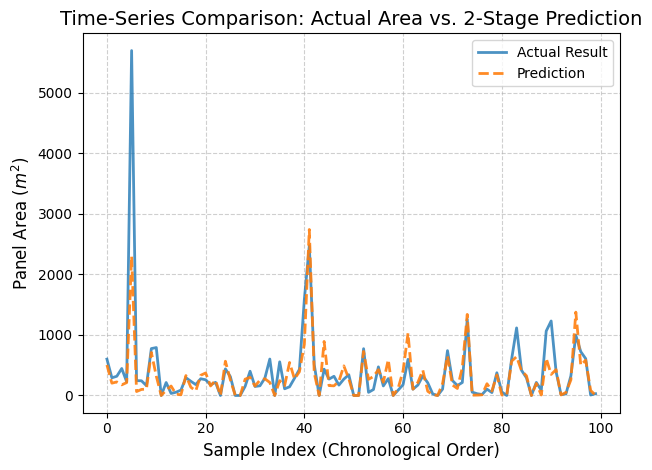

In [20]:
import matplotlib.pyplot as plt

# 1. Select a window to plot (e.g., first 100 samples) 
# If your dataset is small, you can use the whole thing
window = 100 
y_true_subset = y_test_real[:window]
y_pred_subset = y_pred_final[:window]
indices = range(len(y_true_subset))

# 2. Create the plot
plt.plot(indices, y_true_subset, label='Actual Result', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(indices, y_pred_subset, label='Prediction', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.9)

# 3. Formatting
plt.title('Time-Series Comparison: Actual Area vs. 2-Stage Prediction', fontsize=14)
plt.xlabel('Sample Index (Chronological Order)', fontsize=12)
plt.ylabel('Panel Area ($m^2$)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# 4. Save and inspect
plt.tight_layout()


In [30]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:0000:0100:01


Analysis

In [21]:
import shap
import numpy as np


In [22]:
import shap

explainer = shap.TreeExplainer(clf)

X_shap = X_test_1.sample(1000, random_state=42)

shap_values = explainer(X_shap)


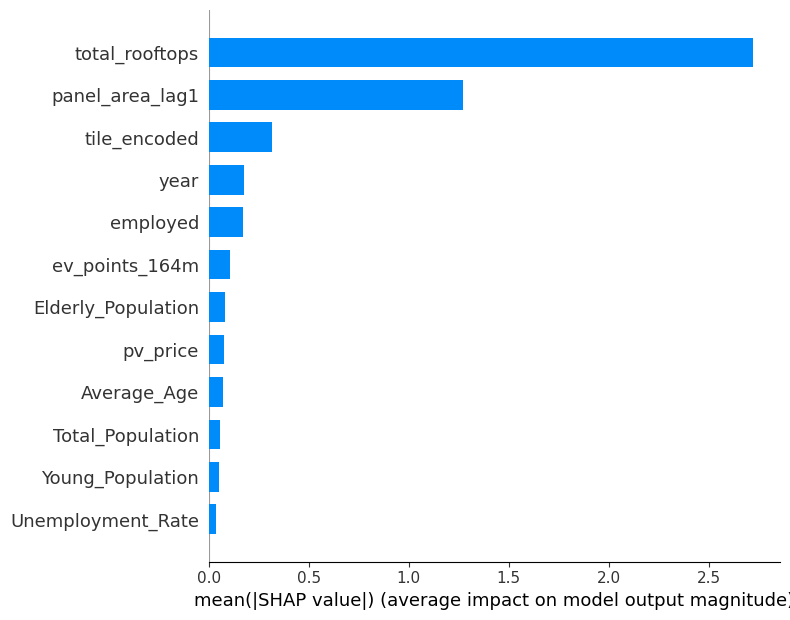

In [23]:
shap.summary_plot(
    shap_values.values,
    X_shap,
    plot_type="bar"
)
